# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com algumas camadas escondidas.


## Importação dos pacotes

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR

import lib.pytorch_trainer_v2 as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [7]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

i = np.arange(len(x))
np.random.shuffle(i)
x = x[i]
y = y[i]

In [8]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [9]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.selu(x)
        x = nn.functional.dropout(x)
        x = self.layer2(x)
        x = F.selu(x)
        x = nn.functional.dropout(x)
        x = self.layer3(x)
        x = F.selu(x)
        x = nn.functional.dropout(x)
        x = self.layer4(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model(
  (layer1): Linear(in_features=13, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=1, bias=True)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.7)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest,ptt.PrintCallback()]
        )

## Treinamento

In [12]:
trainer.fit(50, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=2)

Start training for 50 epochs
  1:   0.4s   T: 169.20162 *   V: 25.03415 *  
  2:   0.2s   T: 21.71506 *   V: 12.56820 *  
  3:   0.2s   T: 17.27636 *   V: 10.75463 *  
  4:   0.2s   T: 16.02575 *   V: 10.77288    
  5:   0.2s   T: 15.14021 *   V: 9.51950 *  
  6:   0.2s   T: 14.41459 *   V: 8.80222 *  
  7:   0.2s   T: 13.50666 *   V: 8.06385 *  
  8:   0.2s   T: 12.39684 *   V: 9.88951    
  9:   0.2s   T: 12.08853 *   V: 7.62502 *  
 10:   0.2s   T: 11.41744 *   V: 7.81386    
 11:   0.2s   T: 11.17441 *   V: 7.68809    
 12:   0.2s   T: 10.05542 *   V: 6.66632 *  
 13:   0.2s   T: 10.00982 *   V: 6.00676 *  
 14:   0.2s   T: 9.67312 *   V: 7.58848    
 15:   0.2s   T: 9.61110 *   V: 5.52252 *  
 16:   0.2s   T: 9.08228 *   V: 6.51788    
 17:   0.2s   T: 9.04413 *   V: 5.97734    
 18:   0.2s   T: 8.74402 *   V: 4.70663 *  
 19:   0.2s   T: 8.46057 *   V: 5.94035    
 20:   0.2s   T: 8.48741     V: 6.29434    
 21:   0.2s   T: 8.23321 *   V: 7.63819    
 22:   0.2s   T: 7.86922 *   

## Avaliação

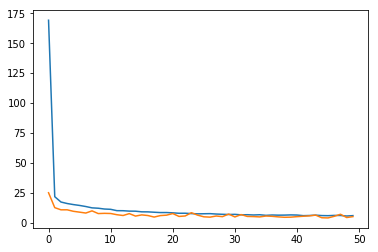

In [13]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [14]:
trainer.load_state('../../models/bostonhousing')

In [15]:
eval = trainer.evaluate(x_train,y_train)
eval

evaluate: 50/50 ok


{'losses': [0.9563005910560548]}

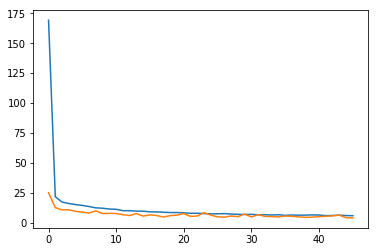

In [16]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [17]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 3.9900218607295344
RMSE: 1.99750390756


In [18]:
o = model(x_train)
print(type(o), o.shape)
comp_compl = np.hstack([y_train.numpy(), o.data.cpu().numpy()])
print(comp_compl.shape)
comp_train = comp_compl[:int(.8 * comp_compl.shape[0])]
comp_valid = comp_compl[int(.8 * comp_compl.shape[0]):]
print(comp_train.shape, comp_valid.shape)

<class 'torch.Tensor'> torch.Size([506, 1])
(506, 2)
(404, 2) (102, 2)


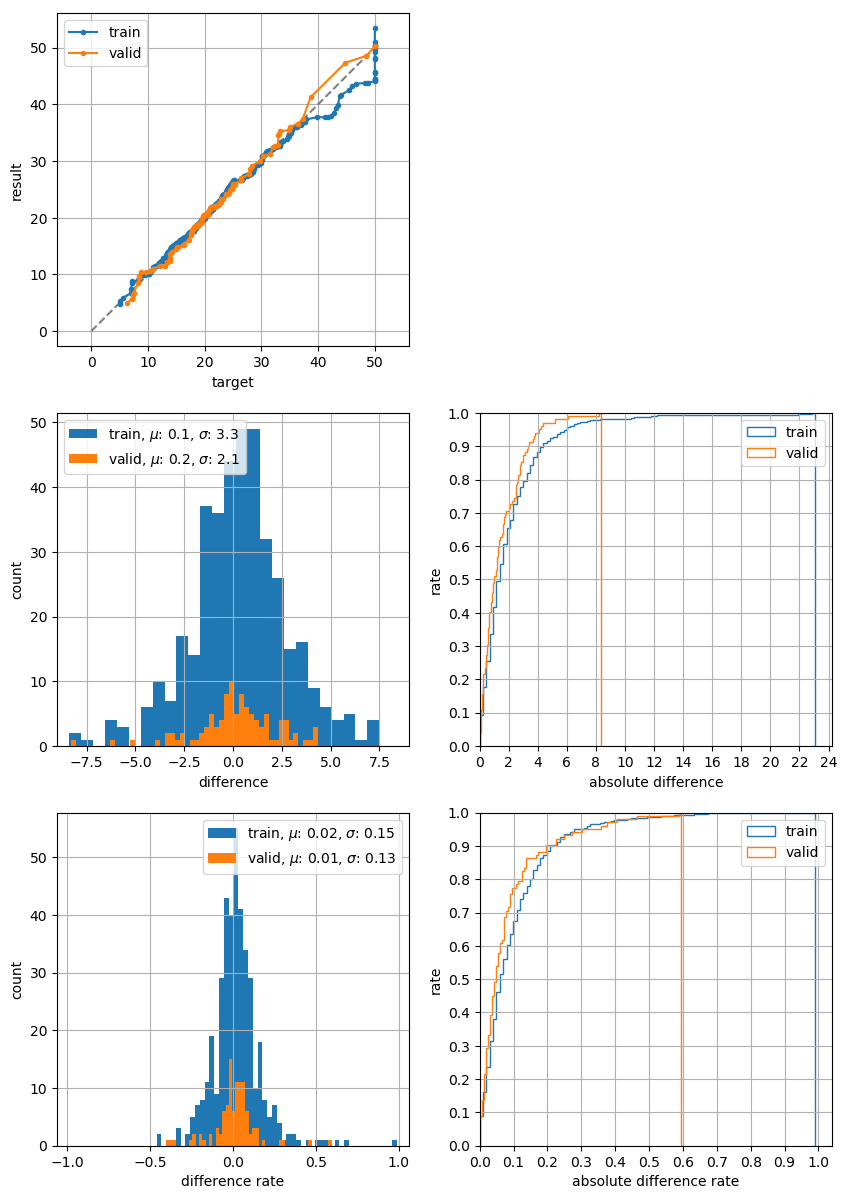

In [20]:
fig = plt.figure(figsize=(10, 15), dpi=100)
n_rows = 3
n_cols = 2

ax = fig.add_subplot(n_rows, n_cols, 1)
ax.set_xlabel('target')
ax.set_ylabel('result')
ax.plot([0., 50.], [0., 50.], '--', color='gray')
for comp, s_comp in zip([comp_train, comp_valid], ['train', 'valid']):
    comp = np.sort(comp, axis=0)
    ax.plot(comp[:, 0], comp[:, 1], marker='.', label=s_comp)
    ax.set_xlim(0., max(ax.get_xlim()[1], ax.get_xlim()[1]))
    ax.set_ylim(0., max(ax.get_xlim()[1], ax.get_xlim()[1]))
ax.legend()
ax.axis('equal')
ax.grid(True)

ax = fig.add_subplot(n_rows, n_cols, 3)
for comp, s_comp in zip([comp_train, comp_valid], ['train', 'valid']):
    a_diff = comp[:, 1] - comp[:, 0]
    ax.hist(a_diff, bins=50, label='{}, $\mu$: {:.1f}, $\sigma$: {:.1f}'.format(s_comp, a_diff.mean(), a_diff.std()))
ax.legend()
ax.set_xlabel('difference')
ax.set_ylabel('count')
ax.set_xlim(-max(ax.get_xlim()), max(ax.get_xlim()))
ax.grid(True)

ax = fig.add_subplot(n_rows, n_cols, 4)
for comp, s_comp in zip([comp_train, comp_valid], ['train', 'valid']):
    a_diff = np.absolute(comp[:, 1] - comp[:, 0])
    ax.hist(a_diff, histtype='step', cumulative=+1, density=True, bins=100, label=s_comp)
ax.legend()
ax.set_xlabel('absolute difference')
ax.set_ylabel('rate')
ax.set_xlim(0., ax.get_xlim()[1])
ax.set_ylim(0., 1.)
ax.set_xticks(np.arange(*ax.get_xlim(), 2.))
ax.set_yticks(np.linspace(0., 1., 11))
ax.grid(True)

ax = fig.add_subplot(n_rows, n_cols, 5)
for comp, s_comp in zip([comp_train, comp_valid], ['train', 'valid']):
    a_diff = comp[:, 1] / comp[:, 0] - 1.
    ax.hist(a_diff, bins=50, label='{}, $\mu$: {:.2f}, $\sigma$: {:.2f}'.format(s_comp, a_diff.mean(), a_diff.std()))
ax.legend()
ax.set_xlabel('difference rate')
ax.set_ylabel('count')
ax.set_xlim(-max(ax.get_xlim()), max(ax.get_xlim()))
ax.grid(True)

ax = fig.add_subplot(n_rows, n_cols, 6)
for comp, s_comp in zip([comp_train, comp_valid], ['train', 'valid']):
    a_diff = np.absolute(comp[:, 1] / comp[:, 0] - 1.)
    ax.hist(a_diff, histtype='step', cumulative=+1, density=True, bins=100, label=s_comp)
ax.legend()
ax.set_xlabel('absolute difference rate')
ax.set_ylabel('rate')
ax.set_xlim(0., ax.get_xlim()[1])
ax.set_ylim(0., 1.)
ax.set_xticks(np.linspace(0., 1., 11))
ax.set_yticks(np.linspace(0., 1., 11))
ax.grid(True)

plt.show()

# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
